# Example-2: MCP Detector Data from DDAS

This is a complete notebook to show how to analysis the MCP detector data from DDAS (which is very similar to PPAC), with pure Python script, the required knowledge about the data is also explained.

The raw event data was generated from DDAS on 2020-12-15, provided by Scott Cogan (BIM), and processed with [h5readout](https://github.com/archman/h5readout) to convert and compress to HDF5 format. 

Tong Zhang (<zhangt@frib.msu.edu>)

2021-06-21

In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
print(f"h5py   version: {h5py.__version__}")
print(f"numpy  version: {np.__version__}")
print(f"pandas version: {pd.__version__}")

h5py   version: 2.10.0
numpy  version: 1.17.4
pandas version: 1.1.4


## Read HDF5 data file

In [3]:
# HDF5 data file
filepath = "../../../nscl_data/DDAS/run-0227-00.evt.h5"
# data could be downloaded from:
# https://gitlab.msu.edu/zhangto71/ddas-data-example/-/raw/master/run-0227-00.evt.h5

In [4]:
# Read .h5 file
f = h5py.File(filepath, "r")

# Get Fragment and Trace data
frag_dset = f['Events']['FragmentData']
trace_dset = f['Events']['TraceData']
frag_df = pd.DataFrame(np.array(frag_dset))

# Show all the metadata of this run.
for k,v in f.attrs.items():
    print(f"{k:<20s} --> {v}")

Begin_Datetime       --> b'Tue Dec 15 13:07:25 2020'
Begin_Timestamp      --> 1608055645
Controller           --> b'DDAS'
Elapsed_Seconds      --> 14399
End_Datetime         --> b'Tue Dec 15 17:07:25 2020'
End_Timestamp        --> 1608070045
Ring_Format          --> b'11.0'
Run_Number           --> 227
Title                --> b'Ch4,5,6,7,8 MCP delayline'
Total_Events         --> 1072931
Total_Fragments      --> 1243462


### Read out fragment data

In [5]:
# Index the Fragment data table
multi = frag_df.set_index(['Event_ID', 'Channel_ID']).sort_index()
df0 = multi.loc[:, ['Time', 'Fragment_ID']]

In [6]:
multi

,,Fragment_ID,Time,Coarse_Time,Energy,Trace_Length,Crate_ID,Slot_ID,Err_Pileup,Err_ADC_Saturation,Err_CFD_Fail,Overflow_Code,ADC_Frequency,ADC_Resolution
Event_ID,Channel_ID,,,,,,,,,,,,,
0,8,0,1.258038e+07,12580370,65521,250,1,2,0,0,0,0,500,14
1,8,1,1.981365e+07,19813650,4,250,1,2,0,0,0,0,500,14
2,8,2,2.577066e+07,25770660,65531,250,1,2,0,0,0,0,500,14
3,8,3,4.574491e+07,45744910,11,250,1,2,0,0,0,0,500,14
4,8,4,4.815011e+07,48150110,25,250,1,2,0,0,0,0,500,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1072926,8,1243457,1.438945e+13,14389449228210,65532,250,1,2,0,0,0,0,500,14
1072927,8,1243458,1.438946e+13,14389458152910,0,250,1,2,0,0,0,0,500,14
1072928,8,1243459,1.438946e+13,14389461968930,65525,250,1,2,0,0,0,0,500,14


### Before processing, you'll have to know:
- The `x` info is from the time difference between (Time value reading of) Channel_ID 4 and 5 in nanosecond
- The `y` info is from the time difference between (Time value reading of) Channel_ID 7 and 6 in nanosecond
- Not all the events (reference by Event_ID) has all the four-channel readings, you'll have to filter out the valid ones

In [7]:
# Filter out all the valid events
df4 = df0[df0.index.isin([4], level='Channel_ID')].reset_index(level='Channel_ID')
df5 = df0[df0.index.isin([5], level='Channel_ID')].reset_index(level='Channel_ID')
df6 = df0[df0.index.isin([6], level='Channel_ID')].reset_index(level='Channel_ID')
df7 = df0[df0.index.isin([7], level='Channel_ID')].reset_index(level='Channel_ID')

In [8]:
# Rename columns
df4.rename(columns={'Channel_ID': 'Ch4', 'Time': 'Time4', 'Fragment_ID': 'FragID4'}, inplace=True)
df5.rename(columns={'Channel_ID': 'Ch5', 'Time': 'Time5', 'Fragment_ID': 'FragID5'}, inplace=True)
df6.rename(columns={'Channel_ID': 'Ch6', 'Time': 'Time6', 'Fragment_ID': 'FragID6'}, inplace=True)
df7.rename(columns={'Channel_ID': 'Ch7', 'Time': 'Time7', 'Fragment_ID': 'FragID7'}, inplace=True)
df = df4.join([df5, df6, df7])
df.dropna(inplace=True)
df.drop(columns=['Ch4', 'Ch5', 'Ch6', 'Ch7'], inplace=True)

In [9]:
# Create new columns for the difference of channel4,5 and 6,7
df['ch45'] = df.Time4 - df.Time5
df['ch76'] = df.Time7 - df.Time6
df = df.astype({'FragID4': 'uint64', 'FragID5': 'uint64',
                'FragID6': 'uint64', 'FragID7': 'uint64'})

### After processing, below is how fragment data look like, for MCP:
- x &rarr; Time difference between (Time value reading of) Channel_ID 4 and 5, represented as ch45 (ch4 - ch5) in the new dataframe
- y &rarr; Time difference between (Time value reading of) Channel_ID 7 and 6, represented as ch76 (ch7 - ch6) in the new dataframe

Note: Only extract event data that has all valid readings at Channel_ID 4,5,6,7.

In [10]:
# final data table with all valid events
df

,Time4,FragID4,Time5,FragID5,Time6,FragID6,Time7,FragID7,ch45,ch76
Event_ID,,,,,,,,,,
66,8.911350e+08,70,8.911350e+08,68,8.911350e+08,66,8.911350e+08,69,3.587402,23.604248
107,1.309412e+09,114,1.309412e+09,111,1.309412e+09,112,1.309412e+09,115,23.518555,3.547363
147,1.849594e+09,155,1.849594e+09,156,1.849594e+09,157,1.849594e+09,158,-8.899902,-0.717773
159,1.976796e+09,175,1.976796e+09,174,1.976796e+09,172,1.976796e+09,173,4.836670,-0.190430
190,2.483480e+09,206,2.483480e+09,207,2.483480e+09,208,2.483480e+09,209,2.273682,-0.878906
...,...,...,...,...,...,...,...,...,...,...
1072822,1.438802e+13,1243334,1.438802e+13,1243335,1.438802e+13,1243336,1.438802e+13,1243337,2.650391,3.513672
1072842,1.438825e+13,1243361,1.438825e+13,1243358,1.438825e+13,1243360,1.438825e+13,1243359,3.513672,0.849609
1072864,1.438853e+13,1243386,1.438853e+13,1243383,1.438853e+13,1243384,1.438853e+13,1243387,32.505859,5.988281


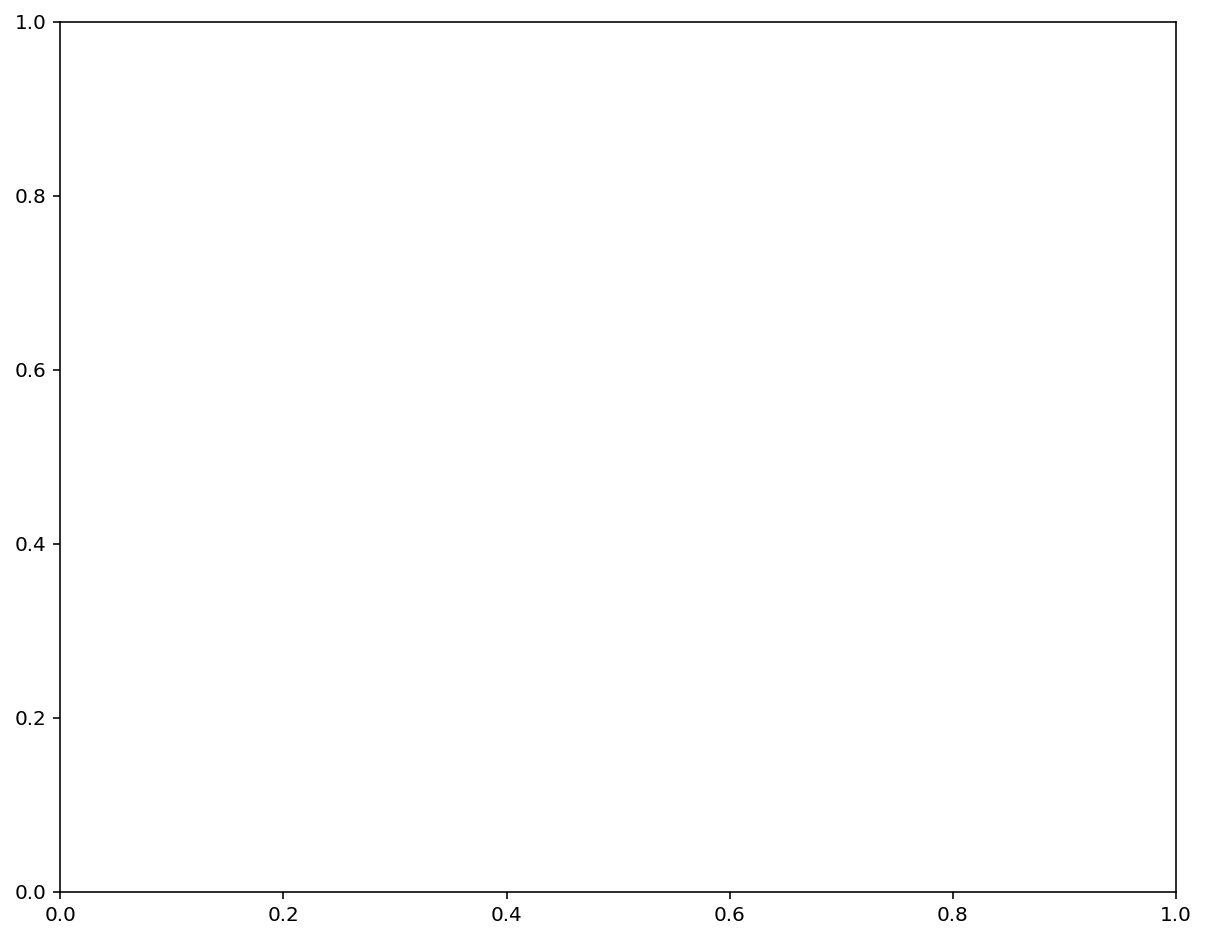

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))

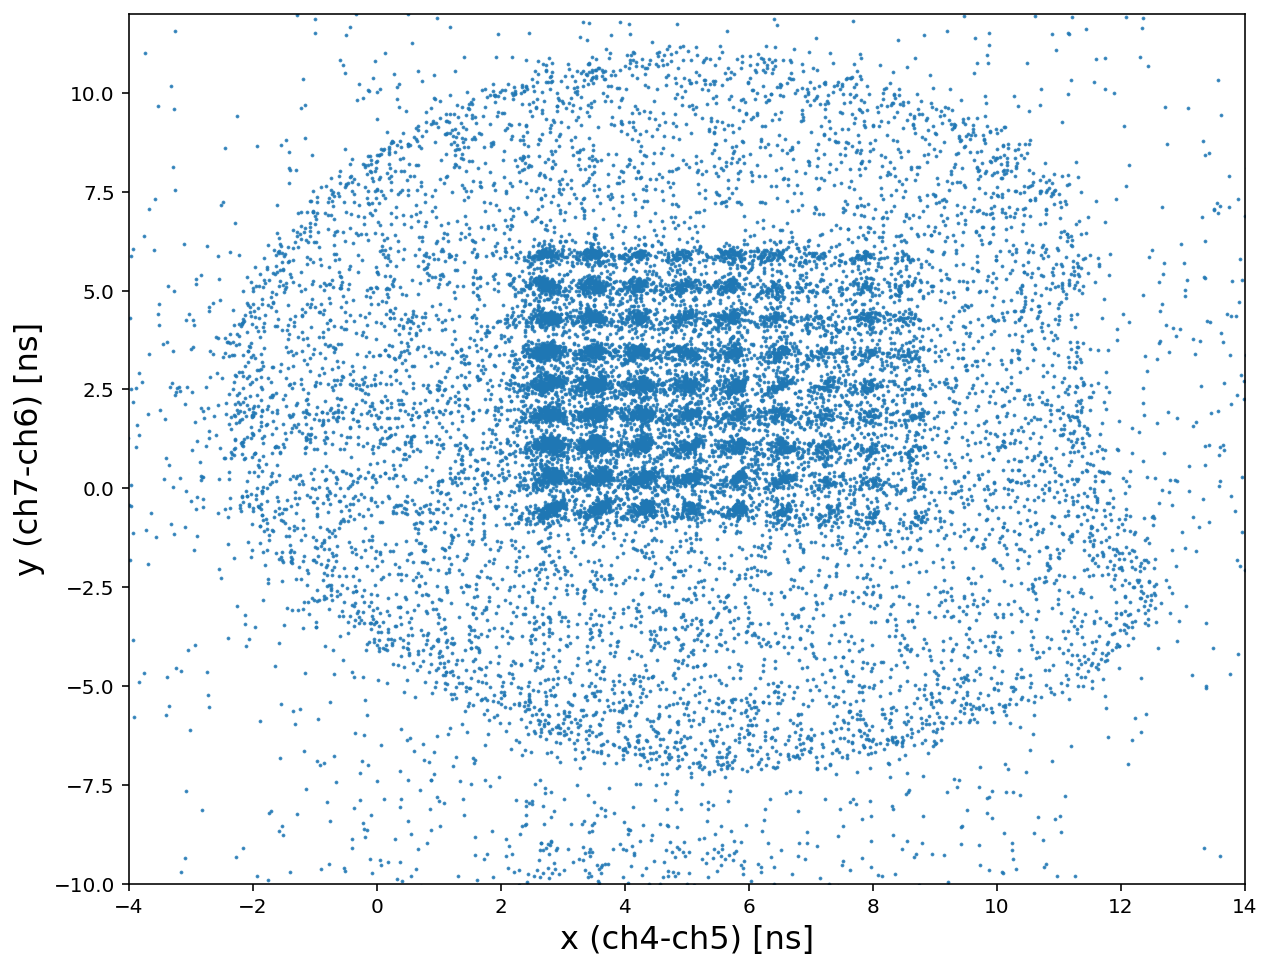

In [12]:
# Plot data
df.plot.scatter(x='ch45', y='ch76', alpha=0.8, s=0.8,
                xlim=[-4, 14], ylim=[-10,12], ax=ax)
ax.set_xlabel("x (ch4-ch5) [ns]", fontsize=16)
ax.set_ylabel("y (ch7-ch6) [ns]", fontsize=16)
fig

## Background noise

Now you may have the needs to suppress the background noise signals, the way to estimate the noise and valid signal is to find out the siangl threshold, which is indicated by Energy column in the FragmentData.

But the Energy value read from FragmentData for this run could not be used (you can see there's lots of saturated readings), the approach below shows how to get 'Energy' info from the orignal TraceData (remember we have another super large table for TraceData under '/Events' group)

In [13]:
trace_df = pd.DataFrame(np.array(trace_dset))

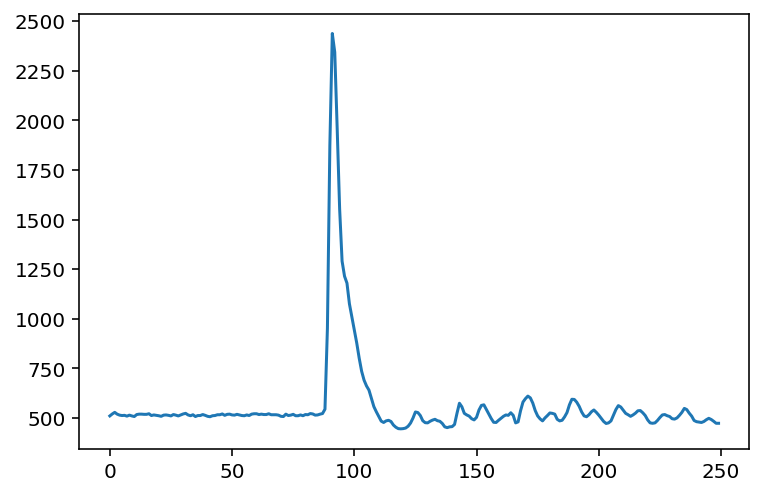

In [14]:
# Typical trace data for Fragment_ID 66 (the first valid fragment of Event 66)
trace_df.iloc[66,:].plot()

The energy signal is correlated with the peak height rising from the lethargy area, the 'Energy' column of FragmentData is processed by the DDAS firmware with the builtin algorithm.

Here, an approximate approach is applied to generate the pseduo energy column, by measuring the peak height from the max and min of the trace data, which is rough by fast.

In [15]:
df_multi = df.reset_index().set_index(['FragID4', 'FragID5', 'FragID6', 'FragID7']).sort_index()
trace_df.set_index(frag_df.Fragment_ID, inplace=True)

In [16]:
# Calculate all the height info for pseduo energy
trace_df['height'] = trace_df.max(axis=1) - trace_df.min(axis=1)
df1 = trace_df.loc[:, ['height']]
df2 = df1.transpose()

In [17]:
# Keep in mind the valid events should have 4 fragments, the two lines below calculate the pseduo energy
# by averaging the 4 height values to be the final Energy info
_ind = [list(i) for i in df_multi.index.to_list()]
df_multi['avg_height'] = [float(df2[_ind[i]].mean(axis=1)) for i in range(len(_ind))]

In [18]:
# Set Event_ID as index
df_final = df_multi.reset_index().set_index('Event_ID').sort_index()

In [19]:
df_final

,FragID4,FragID5,FragID6,FragID7,Time4,Time5,Time6,Time7,ch45,ch76,avg_height
Event_ID,,,,,,,,,,,
66,70,68,66,69,8.911350e+08,8.911350e+08,8.911350e+08,8.911350e+08,3.587402,23.604248,1953.25
107,114,111,112,115,1.309412e+09,1.309412e+09,1.309412e+09,1.309412e+09,23.518555,3.547363,1135.25
147,155,156,157,158,1.849594e+09,1.849594e+09,1.849594e+09,1.849594e+09,-8.899902,-0.717773,196.75
159,175,174,172,173,1.976796e+09,1.976796e+09,1.976796e+09,1.976796e+09,4.836670,-0.190430,1963.00
190,206,207,208,209,2.483480e+09,2.483480e+09,2.483480e+09,2.483480e+09,2.273682,-0.878906,453.75
...,...,...,...,...,...,...,...,...,...,...,...
1072822,1243334,1243335,1243336,1243337,1.438802e+13,1.438802e+13,1.438802e+13,1.438802e+13,2.650391,3.513672,486.00
1072842,1243361,1243358,1243360,1243359,1.438825e+13,1.438825e+13,1.438825e+13,1.438825e+13,3.513672,0.849609,1052.75
1072864,1243386,1243383,1243384,1243387,1.438853e+13,1.438853e+13,1.438853e+13,1.438853e+13,32.505859,5.988281,2471.50


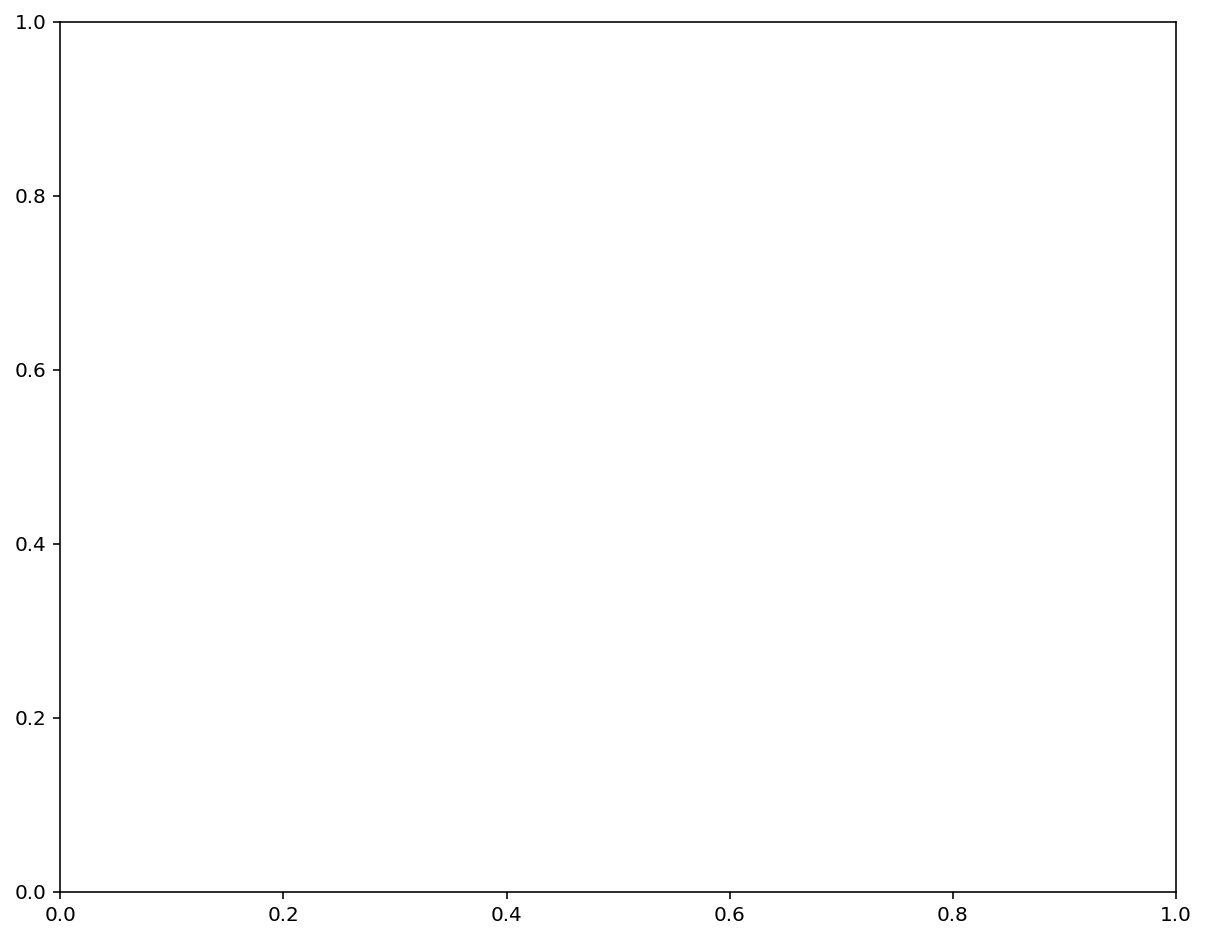

In [20]:
fig, ax = plt.subplots(figsize=(10, 8))

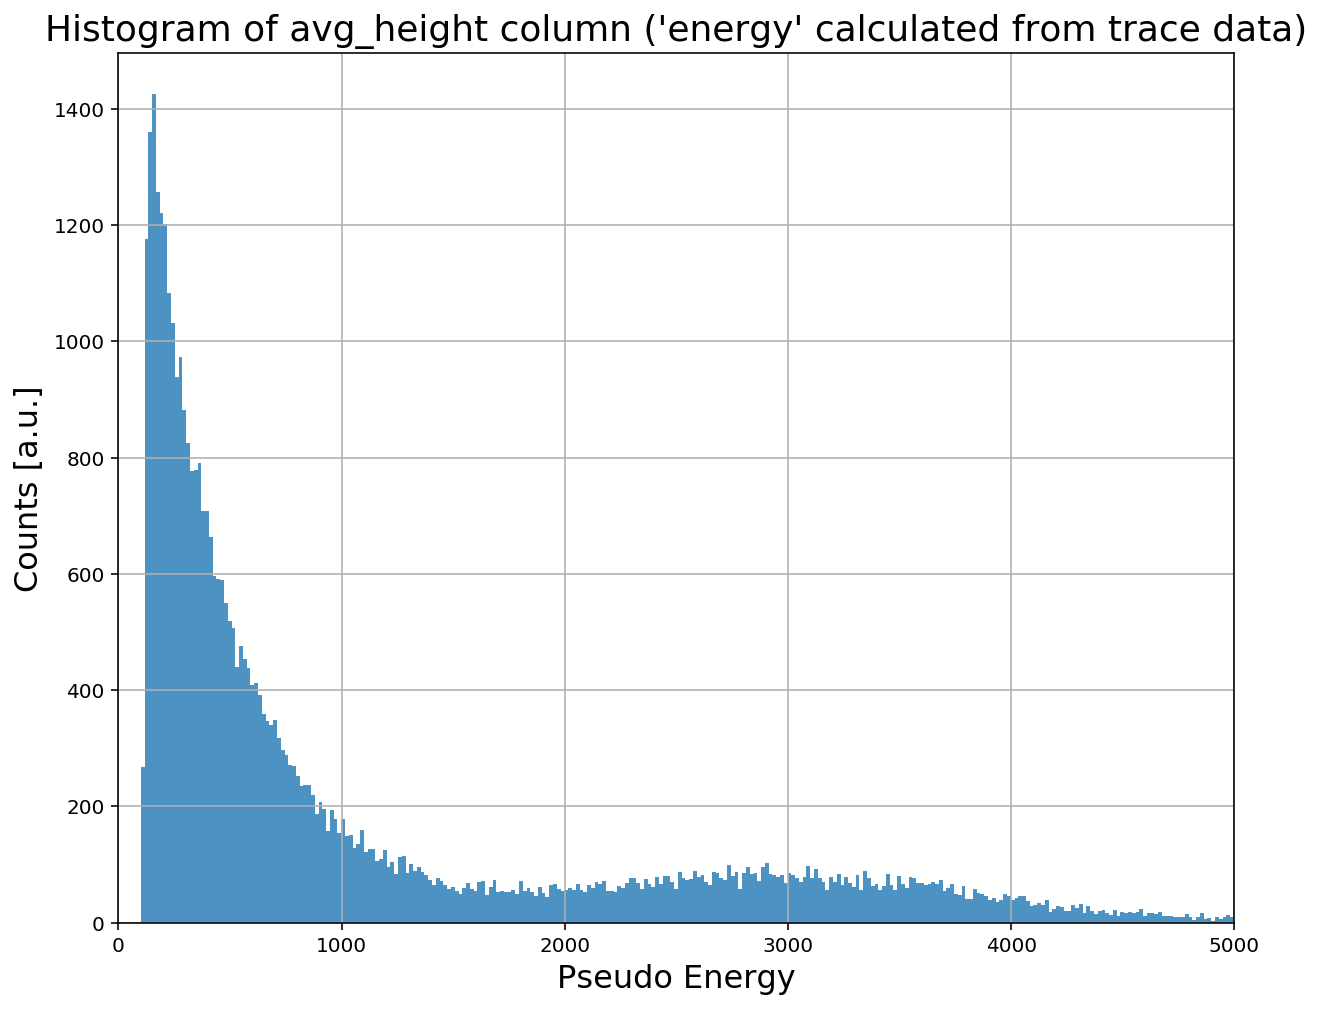

In [21]:
# Histogramming the pseudo energy
df_final.hist('avg_height', bins=500, alpha=0.8, ax=ax)
ax.set_xlim([0, 5000])
ax.set_xlabel('Pseudo Energy', fontsize=16)
ax.set_ylabel('Counts [a.u.]', fontsize=16)
ax.set_title("Histogram of avg_height column ('energy' calculated from trace data)", fontsize=18)
fig

In [22]:
# Set the threshold for the noise/signal, e.g. 1500
df_final_filtered = df_final[df_final.avg_height > 1500]
df_final_noise = df_final[df_final.avg_height <= 1500]

In [23]:
print("Shape of all    data: ", df_final.shape)
print("Shape of signal data: ", df_final_filtered.shape)
print("Shape of noise  data: ", df_final_noise.shape)

Shape of all    data:  (44019, 11)
Shape of signal data:  (11182, 11)
Shape of noise  data:  (32837, 11)


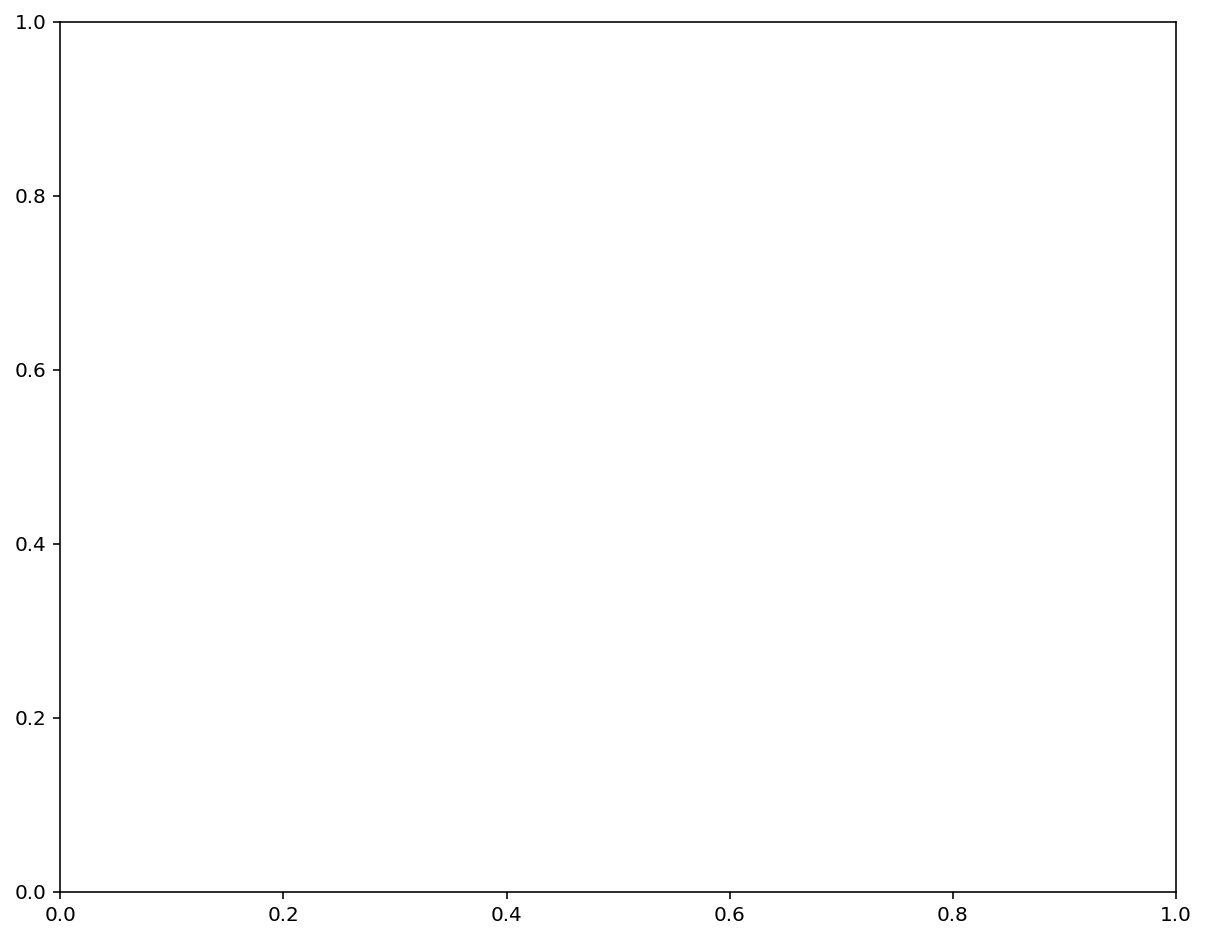

In [24]:
fig, ax = plt.subplots(figsize=(10, 8))

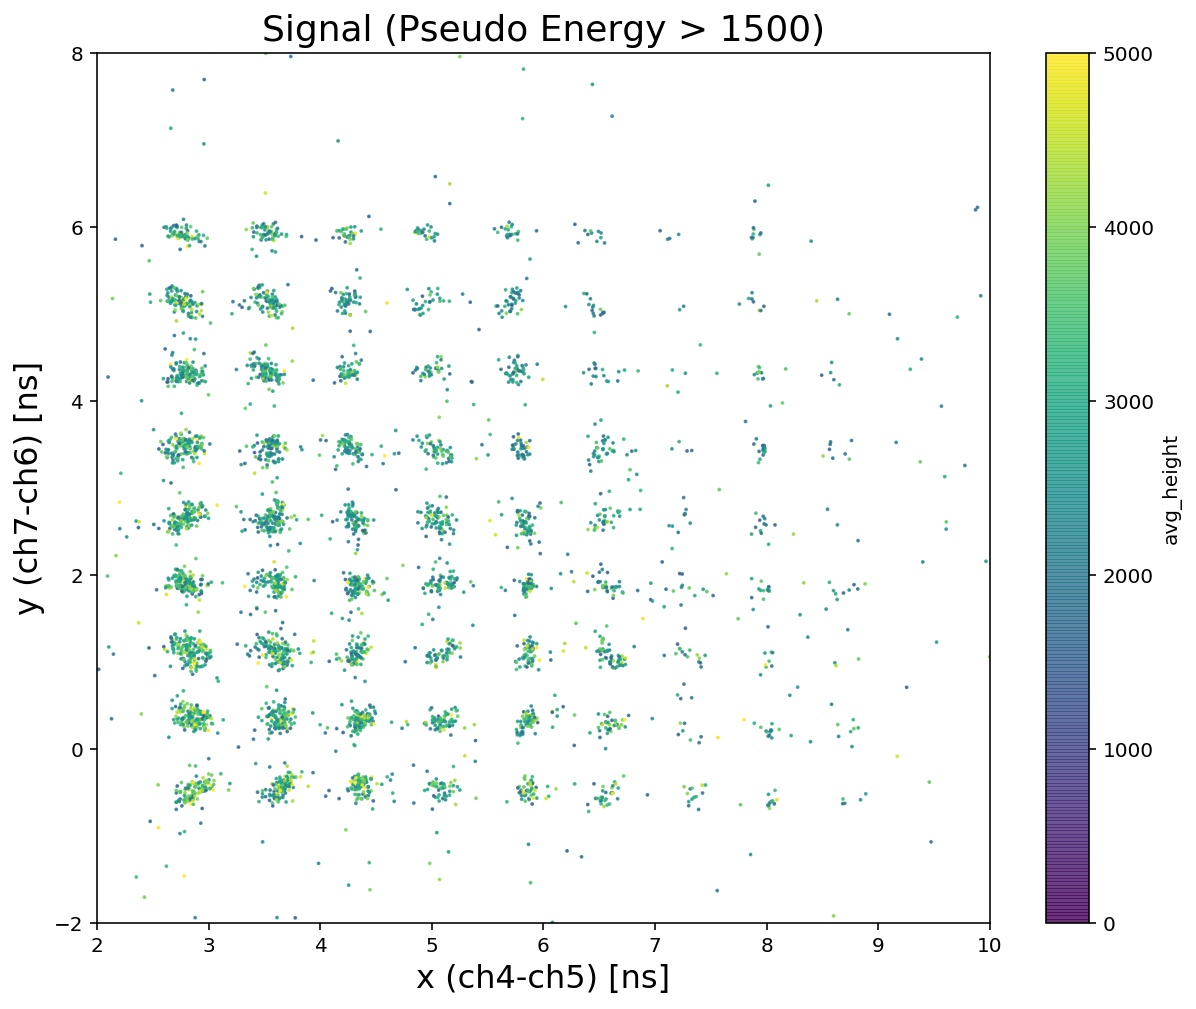

In [25]:
df_final_filtered.plot.scatter(x='ch45', y='ch76', alpha=0.8, s=0.8,
                               c='avg_height', cmap='viridis', vmax=5000, vmin=0,
                               xlim=[2, 10], ylim=[-2, 8], ax=ax)
ax.set_title('Signal (Pseudo Energy > 1500)', fontsize=18)
ax.set_xlabel("x (ch4-ch5) [ns]", fontsize=16)
ax.set_ylabel("y (ch7-ch6) [ns]", fontsize=16)
fig

Text(0.5, 1.0, 'Y')

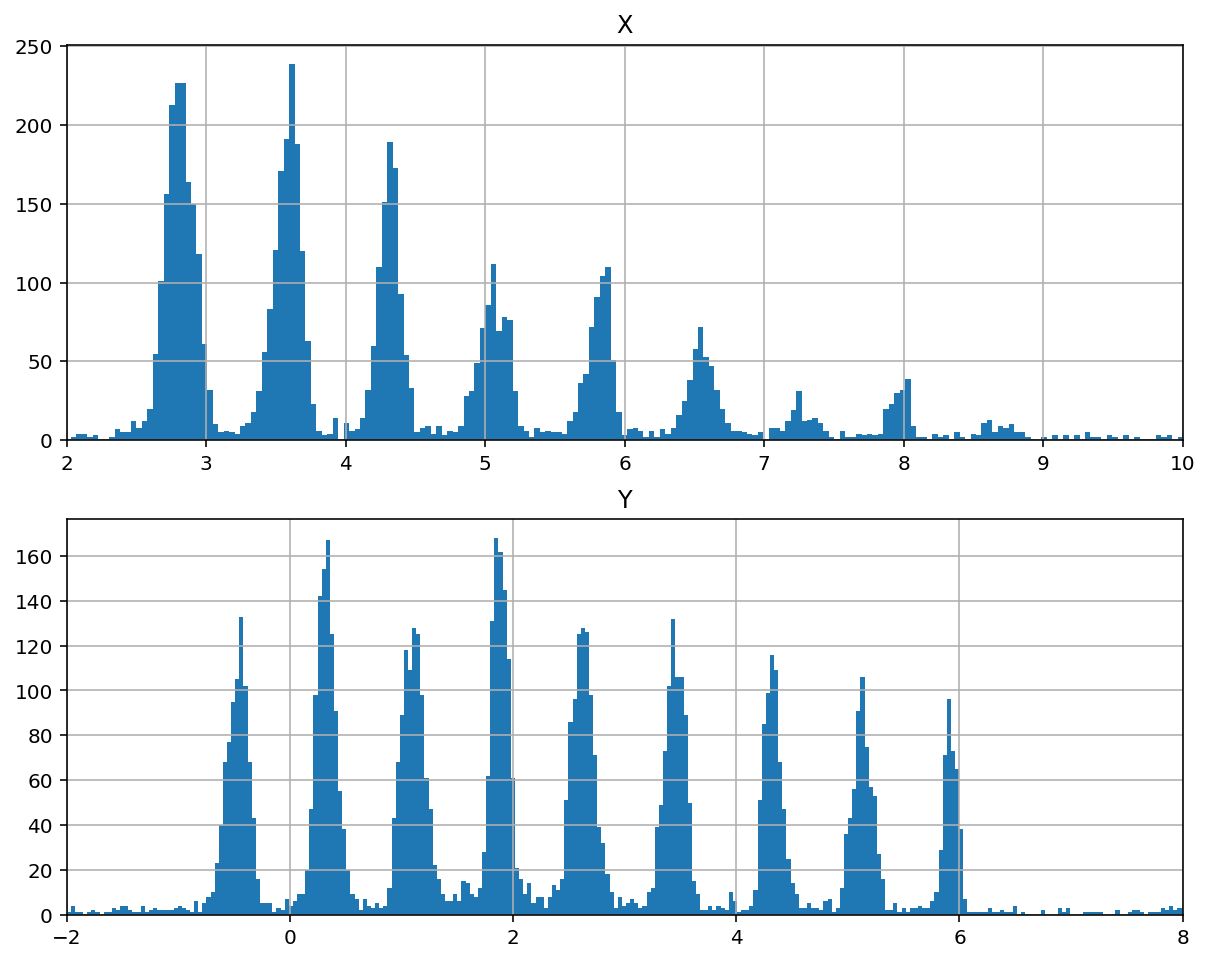

In [26]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 8))
df_final_filtered.ch45.hist(bins=1800, ax=ax1)
df_final_filtered.ch76.hist(bins=1800, ax=ax2)
ax1.set_xlim(2, 10)
ax1.set_title("X")
ax2.set_xlim(-2, 8)
ax2.set_title("Y")